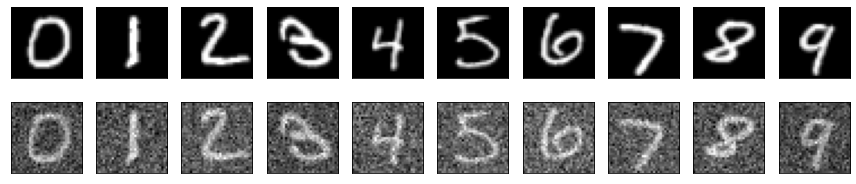

In [51]:
# %% imports
# pytorch
import torch
from torchvision import transforms,datasets
from torch.utils.data import Dataset,DataLoader

# pyplot
import matplotlib.pyplot as plt

# %% Noisy MNIST dataset
class Noisy_MNIST(Dataset):
    # initialization of the dataset
    def __init__(self, split,data_loc,noise=0.5):
        # save the input parameters
        self.split    = split 
        self.data_loc = data_loc
        self.noise    = noise
        
        if self.split == 'train':
            Train = True
        else:
            Train = False
            
        # get the original MNIST dataset   
        Clean_MNIST = datasets.MNIST(self.data_loc, train=Train, download=True)
        
        # reshuffle the test set to have digits 0-9 at the start
        if self.split == 'train':
            data = Clean_MNIST.data.unsqueeze(1)
        else:
            data = Clean_MNIST.data.unsqueeze(1)
            idx = torch.load('test_idx.tar')
            data[:,:] = data[idx,:]
            
        
        # reshape and normalize
        resizer = transforms.Resize(32)
        resized_data = resizer(data)*1.0
        normalized_data = 2 *(resized_data/255) - 1
        #normalized_data = (resized_data - 33)/74
        
        # create the data
        self.Clean_Images = normalized_data
        self.Noisy_Images = normalized_data + torch.randn(normalized_data.size())*self.noise
        self.Labels       = Clean_MNIST.targets
    
    # return the number of examples in this dataset
    def __len__(self):
        return self.Labels.size(0)
    
    # create a a method that retrieves a single item form the dataset
    def __getitem__(self, idx):
        clean_image = self.Clean_Images[idx,:,:,:]
        noisy_image = self.Noisy_Images[idx,:,:,:]
        label =  self.Labels[idx]
        
        return clean_image,noisy_image,label
    
# %% dataloader for the Noisy MNIST dataset
def create_dataloaders(data_loc, batch_size):
    Noisy_MNIST_train = Noisy_MNIST("train", data_loc)
    Noisy_MNIST_test  = Noisy_MNIST("test" , data_loc)
    
    Noisy_MNIST_train_loader =  DataLoader(Noisy_MNIST_train, batch_size=batch_size, shuffle=True,  drop_last=False)
    Noisy_MNIST_test_loader  =  DataLoader(Noisy_MNIST_test , batch_size=batch_size, shuffle=False, drop_last=False)
    
    return Noisy_MNIST_train_loader, Noisy_MNIST_test_loader

# %% test if the dataloaders work
if __name__ == "__main__":
    # define parameters
    data_loc = 'D://5LSL0-Datasets' #change the datalocation to something that works for you
    batch_size = 64
    
    # get dataloader
    train_loader, test_loader = create_dataloaders(data_loc, batch_size)
    
    # get some examples
    examples = enumerate(test_loader)
    _, (x_clean_example, x_noisy_example, labels_example) = next(examples)
    # use these example images througout the assignment as the first 10 correspond to the digits 0-9
    
    # show the examples in a plot
    plt.figure(figsize=(12,3))
    for i in range(10):
        plt.subplot(2,10,i+1)
        plt.imshow(x_clean_example[i,0,:,:],cmap='gray')
        plt.xticks([])
        plt.yticks([])
        
        plt.subplot(2,10,i+11)
        plt.imshow(x_noisy_example[i,0,:,:],cmap='gray')
        plt.xticks([])
        plt.yticks([])
    
    plt.tight_layout()
    plt.savefig("data_examples.png",dpi=300,bbox_inches='tight')
    plt.show()

In [44]:
# Exc 1b)
import torch.nn as nn
import numpy as np
import os
import torch.optim as optim

In [45]:
learning_rate = 1e-2
optimizer = optim.SGD(model.parameters(), lr=learning_rate)
epochs = 10
dir_data = os.path.abspath("data")
dir_truth = os.path.join(dir_data, "gtFine")
torch.save(model.state_dict(), os.path.join("./", "model_unet_base_line.pth"))

In [46]:
class FFNN_1b(nn.Module):
    """
    A simple Feed Forward Neural Network
    
    Param
    ------------
    input_size : int (default = 786)         
        The length of the datasets which is width*height)
    n_hidden : int (default: 200)
        Number of hidden units.
    n_classes: int  (default = 10)        
        Number of the final classes, in our case 0-9 thus 10 classes.
    """
    def __init__(self, input_size=786, hidden_size= 200, n_classes=10):
        super().__init__()
        
        self.flat = nn.Flatten(),
        # First fully connected layer
        self.fc1 = nn.Linear(input_size, hidden_size),

        # Second fully connected layer
        self.fc2 = nn.Linear(hidden_size, n_classes)
        #no activation functions yet
    def forward(self, x):
        # forward always defines connectivity
        y = self.network(x)
        return y
    
    def predict(self,x):
        """Predict class labels
        Parameters
        -----------
        X : array, shape = [n_samples, n_features]
            Input layer with original features.
        Returns:
        ----------
        y_pred : array, shape = [n_samples]
            Predicted class labels.
        """
        # Implement prediction here
        a_out = self.forward(x).detach().numpy()
        result = np.zeros(len(a_out))
        for i in range(len(a_out)):
            j = np.argmax(a_out[i])
            result[i] = j
        y_pred = result
        return y_pred
    
model = FFNN_1b()



In [47]:
def train_part34(model, optimizer, epochs=1, write_to_file=False, USE_GPU=True):
    """
    Fit the model on the training data set.
    Arguments
    ---------
    model : model class
        Model structure to fit, as defined by build_model().
    epochs :  int
        Number of epochs the training should do
    optimizer : optim class
        Optimizer to use
    write_to_file : bool (default:False)
        Write model to file; can later be loaded through load_model()
    USE_GPU : bool (default:True
        Parameters that when set to True uses the GPU for the training
    Returns
    -------
    model : model class
        The trained model.
    """
    # First check if we have GPU we can use to train
    dtype = torch.float32
    if USE_GPU and torch.cuda.is_available():
        device = torch.device('cuda')
    else:
        device = torch.device('cpu')
    model = model.to(device=device)  # Move the model parameters to CPU/GPU
    print_every = 100 # Constant to control how frequently we print train loss
    
    for e in range(epochs):
        for t, (x, y) in enumerate(loader_train):
            model.train()  # put model to training mode
            x = x.to(device=device, dtype=dtype)  # move to device, e.g. GPU
            y = y.to(device=device, dtype=torch.long)

            scores = model(x)
            loss = F.cross_entropy(scores, y)

            # Zero out all of the gradients for the variables which the optimizer
            # will update.
            optimizer.zero_grad()

            # This is the backwards pass: compute the gradient of the loss with
            # respect to each  parameter of the model.
            loss.backward()

            # Actually update the parameters of the model using the gradients
            # computed by the backwards pass.
            optimizer.step()

            if t % print_every == 0:
                print('Iteration %d, loss = %.4f' % (t, loss.item()))
                check_accuracy_part34(loader_val, model)
                print()

    #### Save the model
    print(acc)
    if write_to_file:        
        # Save the weights of the model to a .pt file
#         print(MODEL_NEW)
#         torch.save(model.state_dict(), MODEL_NEW)
        torch.save(model.state_dict(), os.path.join("./", "Saved_Model.pth"))

    return model

In [50]:
pred = model(Noisy_MNIST_test)

NameError: name 'Noisy_MNIST_test' is not defined

In [48]:
# def check_accuracy_part2(loader, model_fn, params):
#     """
#     Check the accuracy of a classification model.
    
#     Inputs:
#     - loader: A DataLoader for the data split we want to check
#     - model_fn: A function that performs the forward pass of the model,
#       with the signature scores = model_fn(x, params)
#     - params: List of PyTorch Tensors giving parameters of the model
    
#     Returns: Nothing, but prints the accuracy of the model
#     """
#     split = 'val' if loader.dataset.train else 'test'
#     print('Checking accuracy on the %s set' % split)
#     num_correct, num_samples = 0, 0
#     with torch.no_grad():
#         for x, y in loader:
#             x = x.to(device=device, dtype=dtype)  # move to device, e.g. GPU
#             y = y.to(device=device, dtype=torch.int64)
#             scores = model_fn(x, params)
#             _, preds = scores.max(1)
#             num_correct += (preds == y).sum()
#             num_samples += preds.size(0)
#         acc = float(num_correct) / num_samples
#         print('Got %d / %d correct (%.2f%%)' % (num_correct, num_samples, 100 * acc))